# Demo: 2D Convolution and Convolutional Layers

In this demo, you will learn to:
* Compute 2D convolutions on images using `scipy`.
* Visualize the outputs of convolutions
* Create a convolutional layer in `pytorch`
* Mathematically describe the weights with multiple input and output channels

## Loading and Displaying Images

We first import several packages.  Two important packages we will use are: 
* `scipy.signal`: sub-package which has useful routines for 2D convolutions
* `skimage.data`: sub-package for getting some basic images
* `skimage.io`: sub-package for reading and saving images

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import skimage.data

We next create a function to display images that we will use throughout the demo.  The function handles both gray-scale and color images.

In [2]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

The `skimage.data` package has several commonly used images in image processing.  We begin by loading the widely-used "cameraman" image.  

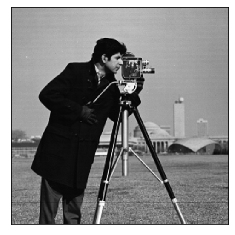

In [3]:
im = skimage.data.camera()
disp_image(im)

Let's print the image shape

In [4]:
print("The image shape is: "+str(im.shape))

The image shape is: (512, 512)


We can also load images from files using the `skimage.io.imread` function.  This function can handle most common image formats including, for example, JPG.

The image shape is: (368, 487, 3)


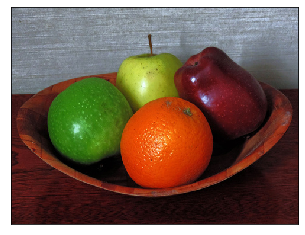

In [5]:
fname = 'still_life.jpg'
im_color = skimage.io.imread(fname)
disp_image(im_color)
print("The image shape is: "+str(im_color.shape))

## Performing 2D Convolutions

To illustrate 2D convolution, we first apply an averaging filter, which essentially replaces each pixel by the average of a neighborhood of KxK pixels to the top left of the current pixel. Filtering an image with this filter has a smoothing effect, which can be useful as a crude noise removal filter. We use this filter to first illustrate the effect of using different output options in convolve2D.

Text(0.5, 1.0, 'Uniform kernel, Valid')

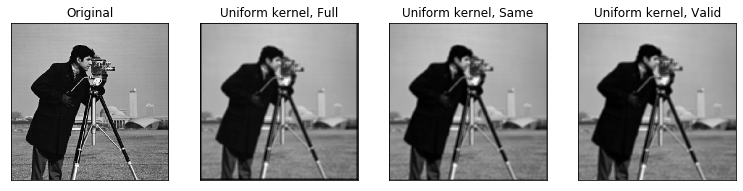

In [6]:
kx = 9
ky = 9
G_unif = np.ones((kx,ky))/(kx*ky)
im_unif_full = scipy.signal.convolve2d(im, G_unif, mode='full')
im_unif_same = scipy.signal.convolve2d(im, G_unif, mode='same')
im_unif_valid = scipy.signal.convolve2d(im, G_unif, mode='valid')

# Plot the original image and the three outputs
plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,4,2)
disp_image(im_unif_full)
plt.title('Uniform kernel, Full')
plt.subplot(1,4,3)
disp_image(im_unif_same)
plt.title('Uniform kernel, Same')
plt.subplot(1,4,4)
disp_image(im_unif_valid)
plt.title('Uniform kernel, Valid')

Let's look at the image sizes. Let K represent the filter width, Ni the image width, and No the output width. With "full", No = Ni+K-1, with "same", No=Ni; with ``valid``, No=Ni-K+1.

In [7]:
print("Input shape = " + str(im.shape))
print("Output shape (full) = " + str(im_unif_full.shape))
print("Output shape (same) = " + str(im_unif_same.shape))
print("Output shape (valid) = " + str(im_unif_valid.shape))

Input shape = (512, 512)
Output shape (full) = (520, 520)
Output shape (same) = (512, 512)
Output shape (valid) = (504, 504)


Now let us take a closer look at the output images in the top left corner.  The zero-padding employed in the `full` and `same` convolutions leads to dark pixels near the boundary.

Text(0.5, 1.0, 'Uniform kernel, Valid')

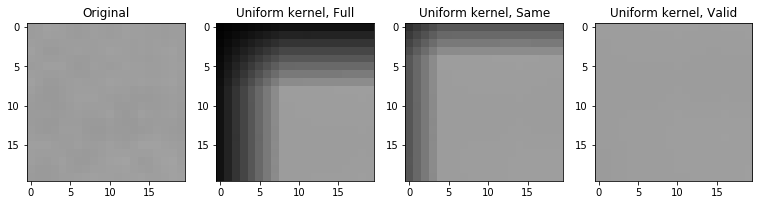

In [8]:
# Plot the original image and the three outputs at the top left corner
plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
plt.imshow(im[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(im_unif_full[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Uniform kernel, Full')
plt.subplot(1,4,3)
plt.imshow(im_unif_same[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Uniform kernel, Same')
plt.subplot(1,4,4)
plt.imshow(im_unif_valid[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Uniform kernel, Valid')

Now let us look at the effect of increasing the average window size. As we can see, the larger K becomes, the more blurred the image becomes.

Text(0.5, 1.0, 'Uniform kernel, 15x15')

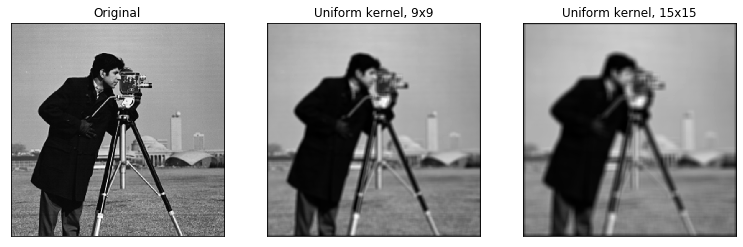

In [9]:
kx = 9
ky = 9
G_unif = np.ones((kx,ky))/(kx*ky)
im_unif_9 = scipy.signal.convolve2d(im, G_unif, mode='same')

kx = 15
ky = 15
G_unif = np.ones((kx,ky))/(kx*ky)
im_unif_15 = scipy.signal.convolve2d(im, G_unif, mode='same')

# Plot the original image and the three outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(im_unif_9)
plt.title('Uniform kernel, 9x9')
plt.subplot(1,3,3)
disp_image(im_unif_15)
plt.title('Uniform kernel, 15x15')

A Gaussian kernel also performs averaging, but it weights the pixels at the center of the kernel more than the uniform filter above did. You can control the amount of blurring using the standard deviation `sigma` of the Gaussian kernel.  To avoid clipping the kernal, make the window size at least 2 times `sigma`.

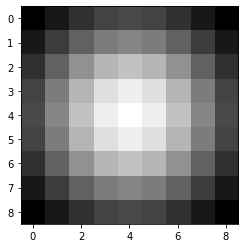

In [10]:
def gauss_kernel(nx,ny,sig):
    """
    Creates a Gaussian kernel of size (nx,ny) with std deviation sig
    """
    dxsq = (np.arange(nx)-(nx-1)/2)**2
    dysq = (np.arange(ny)-(ny-1)/2)**2
    dsq = dxsq[:,None] + dysq[None,:]
    G = np.exp(-0.5*dsq/(sig**2))
    G = G / np.sum(G)
    return G

kx = 9
ky = 9
sig = 3

# Create a Gaussian kernel
G_gauss = gauss_kernel(kx,ky,sig)
plt.imshow(G_gauss,interpolation='None',cmap='gray')

Now let's compare the effect of uniform averaging and Gaussian filtering, with different sizes

Text(0.5, 1.0, 'Gaussian kernel, 15x15')

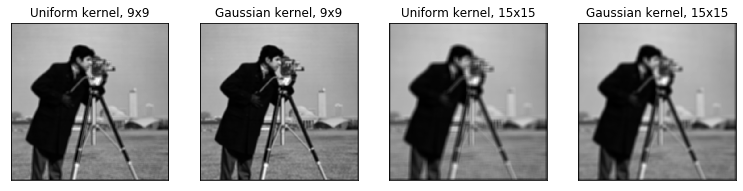

In [11]:
im_gauss_9 = scipy.signal.convolve2d(im, G_gauss, mode='same')

kx = 15
ky = 15
sig = 6

# Create a Gaussian kernel
G_gauss = gauss_kernel(kx,ky,sig)
im_gauss_15 = scipy.signal.convolve2d(im, G_gauss, mode='same')

plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
disp_image(im_unif_9)
plt.title('Uniform kernel, 9x9')
plt.subplot(1,4,2)
disp_image(im_gauss_9)
plt.title('Gaussian kernel, 9x9')
plt.subplot(1,4,3)
disp_image(im_unif_15)
plt.title('Uniform kernel, 15x15')
plt.subplot(1,4,4)
disp_image(im_gauss_15)
plt.title('Gaussian kernel, 15x15')

Another common use of convolution is edge detection.  For this, we use a set of filters that approximate the gradient operation in the horizontal and vertical directions.  One such set is the [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator), `Gx` and `Gy`.  The filter `Gx` responds to changes in the x-direction (vertical edges) while the filter `Gy` responds to changes in the y-direction (horizontal edge).   In any constant region of the image, the output of these filters will be zero.  Without filter reversal, the response is positive if the change is from black to white.

(510, 510)


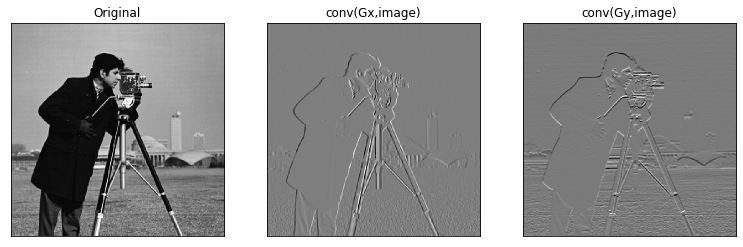

In [12]:
Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])  # Gradient operator in x-direction
Gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])  # Gradient operator in y-direction

imx = scipy.signal.convolve2d(im, Gx, mode='valid') # Perform the convolution
imy = scipy.signal.convolve2d(im, Gy, mode='valid') # Perform the convolution

# Plot the original image and the two outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(imx)
plt.title('conv(Gx,image)')
plt.subplot(1,3,3)
disp_image(imy)
plt.title('conv(Gy,image)')
print(imx.shape)

Now let us see the result with the flipped filter. As can be seen, with filter reversal, the response is positive if the change is from white to black. This is in fact the result of correlating the filter mask with the local neighborhood.

(510, 510)


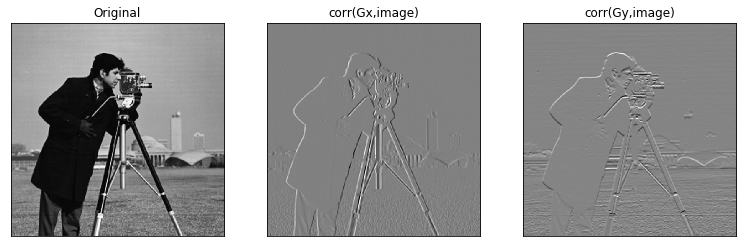

In [13]:
Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])  # Gradient operator in x-direction
Gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])  # Gradient operator in y-direction

imx = scipy.signal.correlate2d(im, Gx, mode='valid') # Perform the correlation
imy = scipy.signal.correlate2d(im, Gy, mode='valid') # Perform the correlation

# Plot the original image and the two outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(imx)
plt.title('corr(Gx,image)')
plt.subplot(1,3,3)
disp_image(imy)
plt.title('corr(Gy,image)')
print(imx.shape)

## Implementing a Convolutional Layer in PyTorch

We now show how to implement a convolutional layer in PyTorch.  

First, we import the appropriate PyTorch packages.  

In [14]:
import torch
import torch.nn as nn

PyTorch usually works on batches of images, which are represented as 4th order tensors with dimensions `(batch_size,nchannels,height,width)`.  Here, `batch_size` is the number of images in a batch, `nchannels` is the number of image channels (such as 3 for {R,G,B}), and `(height,width)` are the image dimensions.  For greyscale images, `nchannels=1`.  We first reshape our image into this format.

In [15]:
print("Image shape in NumPy is "+str(im.shape))
nrow, ncol = im.shape 

# convert to PyTorch batch
nimage = 1         # number of images in batch = 1 since we only have one image
nchan_in = 1       # number of input channels = 1 since it is a greyscale image
batch_shape = (nimage,nchan_in,nrow,ncol)  # batch shape in PyTorch
x = im.reshape(batch_shape)
x_torch = torch.Tensor(x)
print("Batch shape in PyTorch is "+str(x_torch.size()))

Image shape in NumPy is (512, 512)
Batch shape in PyTorch is torch.Size([1, 1, 512, 512])


We now create a simple network with one convolutional layer and two output channels.

In [16]:
model = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=Gx.shape)

The weights are represented as a tensor of size `(2,1,3,3)`, which corresponds to `(nchan_out,nchan_in,krow,kcol)`.  In other words, for each input and output channel pair, there is one kernel of size `(krow,kcol)`. The bias has size `(nchan_out)` corresponding to one bias value per output channel.

In [17]:
state_dict = model.state_dict()
W = state_dict['weight']
b = state_dict['bias']

print("W shape = " + str(W.shape))
print("b shape = " + str(b.shape))

W shape = torch.Size([2, 1, 3, 3])
b shape = torch.Size([2])


We set the two filters at the Sobel filters `Gx` and `Gy` and set the biases to zero.  

In [18]:
# Extend kernels to tensor
W[0,0,:,:] = torch.Tensor(Gx)
W[1,0,:,:] = torch.Tensor(Gy)
b = torch.zeros(2)

# load into PyTorch model
state_dict['bias'] = b
state_dict['weight'] = W
model.load_state_dict(state_dict)

We now run the image through the convolutional layer, convert the result to NumPy, and display the output dimensions.  As expected, it is a 4th order tensor with dimensions `(batch_size,nchannels,height,width)`.

In [19]:
# Process data
y_torch = model(x_torch)
y = y_torch.detach().numpy()

print(y.shape)

(1, 2, 510, 510)


Now we extract the images from the two channels and plot each of them, along with the original image.

(510, 510)


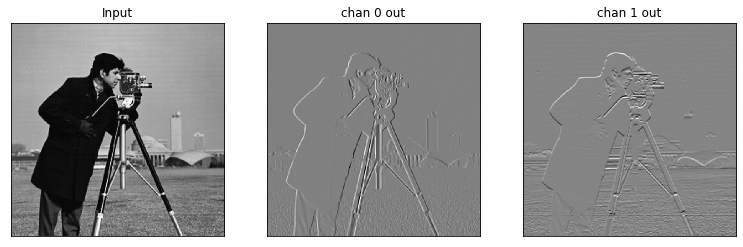

In [20]:
# Plot the original image and the two outputs
chan0=y[0,0,:,:];
chan1=y[0,1,:,:];

plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Input')
plt.subplot(1,3,2)
disp_image(chan0)
plt.title('chan 0 out')
plt.subplot(1,3,3)
disp_image(chan1)
plt.title('chan 1 out')

print(chan0.shape)

We can see that the PyTorch convolutional layer produces the same outputs as we did earlier using scipy.signal.convolve2d with filter flipping.  This is because the "convolution" performed by PyTorch is actually correlation.  

Also, we can see from the size of the output images that the convolution is of the `valid` type (i.e., no zero-padding).  Note that you can choose other amounts zero-padding using the ``padding`` option in `nn.Conv2d`.

## Using Multiple Input and Output Channels

We now do a similar experiment with the color image that we loaded earlier into `im_color`.  Because it is a color image, it has {R,G,B} channels.  

First let's display the image and get its NumPy dimensions.

Image shape in NumPy is (368, 487, 3)


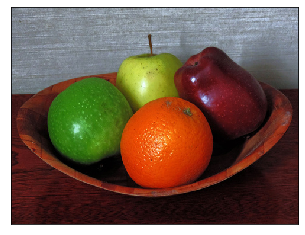

In [21]:
disp_image(im_color)

print("Image shape in NumPy is "+str(im_color.shape))
nrow,ncol,nchan_in = im_color.shape

Now let's convert the image to the PyTorch batch format

In [22]:
# convert to PyTorch batch
nimage = 1
batch_shape = (nimage,nchan_in,nrow,ncol) # batch shape in PyTorch
x = im_color.transpose((2,0,1)).reshape(batch_shape) # move channels to first dimension, then reshape
x_torch = torch.Tensor(x)
print("Batch shape in PyTorch is "+str(x_torch.size()))

Batch shape in PyTorch is torch.Size([1, 3, 368, 487])


We now create a PyTorch network that has a single convolutional layer with `nchan_in=3` input channels and `nchan_out=4` output channels, and a convolutional kernel of size 9x9.

In [23]:
# Dimensions
nchan_in = 3
nchan_out = 4
kernel_size = (9,9)

# Create network
model = nn.Conv2d(nchan_in,nchan_out,kernel_size)

Notice that the number of parameters for each output channel is nchan_in * kernel_size + 1 (for the bias). Thus the total number for nchan_out output channels is nchan_out * (nchan_in * kernel_size + 1) = 4 * (3 * 81+1) = 976!

As before, the weight tensor is of size `(nchan_out,nchan_in,krow,kcol)`, which includes one convolution kernel of size `(krow,kcol)` for each input-output channel pair.

In [24]:
state_dict = model.state_dict()
W = state_dict['weight']
b = state_dict['bias']
print(W.shape)
print(b.shape)

torch.Size([4, 3, 9, 9])
torch.Size([4])


To illustrate multichannel 2D convolutions, we create kernels of the form:

    W[i,j,a,b] = G[a,b]*color_wt[i,j]
    
where `color_wt[i,j]` is the weighting of input color channel `j` when creating output channel `i`, and `G[:,:]` is a Gaussian kernel over the image space.  As before, the bias terms are set to zero.

In [25]:
# Color weights
color_wt = np.array([
    [1,    -0.5, -0.5],   # Sensitive to red
    [-0.5,    1, -0.5],   # Sensitive to green
    [-0.5, -0.5,    1],   # Sensitive to blue
    [ 0.5,   -1,  0.5],   # Sensitive to red-blue mix
])

# Gaussian kernel for convolution over the image space
krow, kcol = kernel_size
G = gauss_kernel(krow,kcol,sig=2)

# Extend kernels to tensor using color weights
W = G[None,None,:,:]*color_wt[:,:,None,None]
b = np.zeros(b.shape)

# load into PyTorch model
state_dict['weight'] = torch.Tensor(W)
state_dict['bias'] = torch.Tensor(b)
model.load_state_dict(state_dict)

Let's plot the filters.  We can think of the filter for each output channel as a small RGB image, where the color indicates which input color it is most sensitive to.

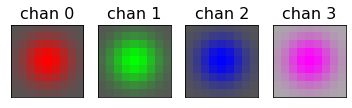

In [26]:
for i in range(nchan_out):
    plt.subplot(1,nchan_out,i+1)
    display_weights = W[i,:,:,:].transpose(1,2,0) # move color channel to end
    disp_image(display_weights)
    title_str = 'chan %d' % i
    plt.title(title_str,fontsize=16)

We now run the image through the network.  We see that the output feature maps clearly indicate the different colors.

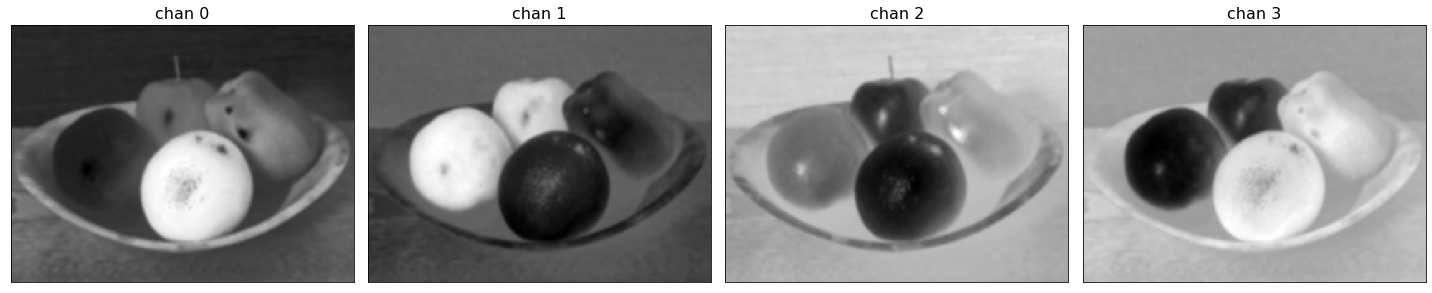

In [27]:
y_torch = model(x_torch)
y = y_torch.detach().numpy()

plt.figure(figsize=(20,20))
for i in range(nchan_out):
    plt.subplot(2,nchan_out,i+1)
    disp_image(y[0,i,:,:])
    title_str = 'chan %d' % i
    plt.title(title_str,fontsize=16)
plt.tight_layout()